По датасету из вложения построить наилучший бинарный классификатор, целевой столбец – mark. Оформить в виде jupyter notebook либо .py скрипта (тогда вывод должен быть описан в отдельном файле txt/excel/etc.).

По стеку ограничений нет. Срок 1 день.

In [291]:
import torch
import numpy as np
import pandas as pd
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score
import matplotlib.pyplot as plt
import catboost.datasets as cbd
from sklearn.model_selection import GridSearchCV



In [270]:
#dowload data
file_name = 'result_set.xlsx' 
df = pd.read_excel(file_name)
print(df.head())

       Ft 0      Ft 1      Ft 2      Ft 3       Ft 4      Ft 5       Ft 6  \
0  1.620967  1.056248  0.114203  6.175593   5.625789  0.581535   7.360085   
1  1.274494  0.814288  0.727210  3.606359   1.493780  7.810750  20.314335   
2  0.569931  1.607170  0.479581  3.521474   1.663726  2.297903  12.839282   
3  0.547560  1.724393  0.682358  1.809472  10.149721  2.999319  49.108530   
4  1.798884  1.748245  1.045646  1.560427   1.269053  1.403952   5.270951   

   Ft 7    Ft 8      Ft 9  Ft 10  Ft 11  Ft 12  Ft 13  Ft14        Ft15  \
0    68    male  very_low  535.0   True      5      5     0         NaN   
1    24  female      high  846.0  False      3      1     1  quite rich   
2    67    male      high  782.0  False      0      0     0    moderate   
3    42    male    medium  132.0  False      3      3     0  quite rich   
4    84    male  very_low  708.0  False      0      0     0         NaN   

                  Ft16  Ft17  mark  
0                  car     0     0  
1           

In [271]:
# print the size of data
print(df.shape)

(5000, 19)


In [272]:
# replace Nan to NULL because if I drop all NaN, I lost around 20% of data
df = df.fillna('')
df = df.replace('', 'NULL')

print(df.shape)
df.head()


(5000, 19)


,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 8,Ft 9,Ft 10,Ft 11,Ft 12,Ft 13,Ft14,Ft15,Ft16,Ft17,mark
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,7.360085,68,male,very_low,535.0,True,5,5,0,NULL,car,0,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,20.314335,24,female,high,846.0,False,3,1,1,quite rich,car,1,0
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,12.839282,67,male,high,782.0,False,0,0,0,moderate,furniture/equipment,1,0
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,49.108530,42,male,medium,132.0,False,3,3,0,quite rich,car,0,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,5.270951,84,male,very_low,708.0,False,0,0,0,NULL,radio/TV,1,0


In [273]:
# drop target value
X=df.drop('mark', axis=1)
X

,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 8,Ft 9,Ft 10,Ft 11,Ft 12,Ft 13,Ft14,Ft15,Ft16,Ft17
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,7.360085,68,male,very_low,535.0,True,5,5,0,NULL,car,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,20.314335,24,female,high,846.0,False,3,1,1,quite rich,car,1
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,12.839282,67,male,high,782.0,False,0,0,0,moderate,furniture/equipment,1
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,49.108530,42,male,medium,132.0,False,3,3,0,quite rich,car,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,5.270951,84,male,very_low,708.0,False,0,0,0,NULL,radio/TV,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.559134,0.536588,1.279125,0.929000,7.795273,0.516629,3.664827,18,male,high,243.0,False,4,3,0,NULL,car,1
4996,1.857942,0.976926,0.513208,0.707998,0.176079,0.444542,10.778070,78,male,high,643.0,True,2,2,0,moderate,domestic appliances,0
4997,1.207780,0.782006,0.557193,0.186188,1.029377,0.546945,16.717601,70,male,low,690.0,True,5,3,0,little,domestic appliances,0
4998,0.579599,1.191785,0.499301,1.139520,0.080799,0.261127,23.748920,84,female,very_low,498.0,False,5,3,0,little,radio/TV,0


In [274]:
#get target value
target=df['mark']
target

0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: mark, Length: 5000, dtype: int64

In [275]:
# find all numerical and categorical features 
numeric_indices = np.array([0, 1, 2, 3, 4, 5 ,6, 7, 10, 12, 13, 14, 17])
categorical_indices = np.array([8, 9, 11, 15, 16])

In [276]:
#  look at numerical data
numeric_data = X[X.columns[numeric_indices]]
numeric_data.head()

,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 10,Ft 12,Ft 13,Ft14,Ft17
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,7.360085,68,535.0,5,5,0,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,20.314335,24,846.0,3,1,1,1
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,12.839282,67,782.0,0,0,0,1
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,49.108530,42,132.0,3,3,0,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,5.270951,84,708.0,0,0,0,1


In [277]:
#  look at categorial data
categorial_data = X[X.columns[categorical_indices]]
categorial_data.head()

,Ft 8,Ft 9,Ft 11,Ft15,Ft16
0,male,very_low,True,NULL,car
1,female,high,False,quite rich,car
2,male,high,False,moderate,furniture/equipment
3,male,medium,False,quite rich,car
4,male,very_low,False,NULL,radio/TV


In [278]:
#split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X.values, target.values,
                                                       train_size=0.8,
                                                       random_state=42)

In [314]:
clf = catboost.CatBoostClassifier(cat_features=categorical_indices)

# list a few parameters that we can tune 
param_grid = {
    
    
    'learning_rate': [0.01, 0.03, 0.001],
    'depth': [1, 2, 3, 4, 5],
    'l2_leaf_reg': [1, 3, 5],
    'n_estimators' : [200,500]
}

#  GridSearchCV
search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='f1')

# start to search parameters
search.fit(X_train, y_train)

# print the best result of GridSearch
print(search.best_params_)

0:	learn: 0.6269786	total: 14.1ms	remaining: 7.04s
1:	learn: 0.5689462	total: 30ms	remaining: 7.48s
2:	learn: 0.5176138	total: 48ms	remaining: 7.96s
3:	learn: 0.4702951	total: 65.7ms	remaining: 8.14s
4:	learn: 0.4285721	total: 82.8ms	remaining: 8.2s
5:	learn: 0.3918134	total: 99.7ms	remaining: 8.21s
6:	learn: 0.3576008	total: 122ms	remaining: 8.57s
7:	learn: 0.3254129	total: 143ms	remaining: 8.81s
8:	learn: 0.2983730	total: 163ms	remaining: 8.88s
9:	learn: 0.2742962	total: 183ms	remaining: 8.96s
10:	learn: 0.2534970	total: 202ms	remaining: 8.97s
11:	learn: 0.2351802	total: 222ms	remaining: 9.02s
12:	learn: 0.2187406	total: 241ms	remaining: 9.03s
13:	learn: 0.2036668	total: 260ms	remaining: 9.03s
14:	learn: 0.1898497	total: 280ms	remaining: 9.05s
15:	learn: 0.1774604	total: 303ms	remaining: 9.16s
16:	learn: 0.1659198	total: 326ms	remaining: 9.27s
17:	learn: 0.1555221	total: 351ms	remaining: 9.41s
18:	learn: 0.1453916	total: 376ms	remaining: 9.53s
19:	learn: 0.1374449	total: 397ms	remain

In [315]:
# fit model with the best parameters
boosting_model = catboost.CatBoostClassifier(n_estimators=500,
                                             cat_features=categorical_indices, depth = 3, l2_leaf_reg= 3, learning_rate= 0.03)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]


0:	learn: 0.6269786	total: 14ms	remaining: 7.01s
1:	learn: 0.5689462	total: 29.5ms	remaining: 7.36s
2:	learn: 0.5176138	total: 45ms	remaining: 7.46s
3:	learn: 0.4702951	total: 65.5ms	remaining: 8.12s
4:	learn: 0.4285721	total: 89.5ms	remaining: 8.86s
5:	learn: 0.3918134	total: 113ms	remaining: 9.31s
6:	learn: 0.3576008	total: 135ms	remaining: 9.53s
7:	learn: 0.3254129	total: 154ms	remaining: 9.46s
8:	learn: 0.2983730	total: 172ms	remaining: 9.39s
9:	learn: 0.2742962	total: 190ms	remaining: 9.32s
10:	learn: 0.2534970	total: 210ms	remaining: 9.35s
11:	learn: 0.2351802	total: 229ms	remaining: 9.3s
12:	learn: 0.2187406	total: 265ms	remaining: 9.91s
13:	learn: 0.2036668	total: 312ms	remaining: 10.8s
14:	learn: 0.1898497	total: 334ms	remaining: 10.8s
15:	learn: 0.1774604	total: 367ms	remaining: 11.1s
16:	learn: 0.1659198	total: 393ms	remaining: 11.2s
17:	learn: 0.1555221	total: 415ms	remaining: 11.1s
18:	learn: 0.1453916	total: 447ms	remaining: 11.3s
19:	learn: 0.1374449	total: 485ms	remaini

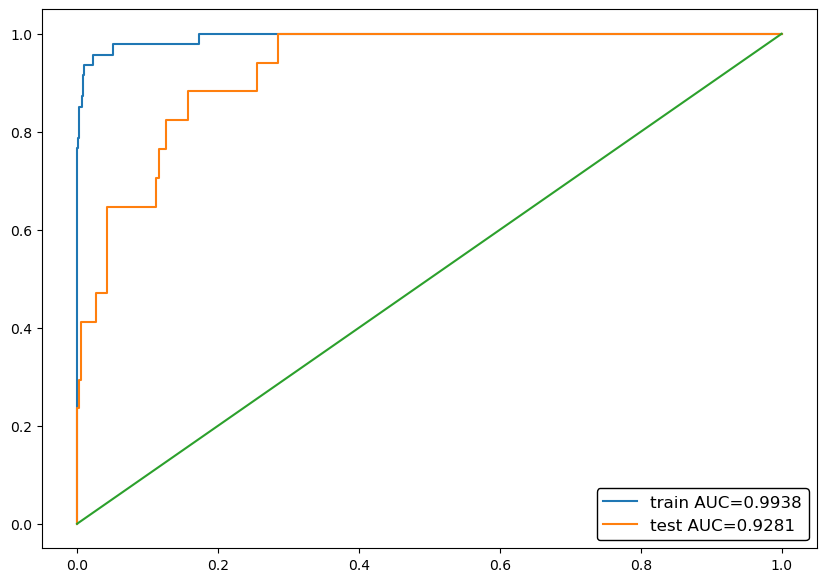

In [316]:
#plot roc_auc metric
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [317]:
y_test_predict = boosting_model.predict(X_test)
y_train_predict = boosting_model.predict(X_train)


In [318]:
#calculate other metrics for train and test data
print('train')
print ( 'Accuracy:', accuracy_score(y_train, y_train_predict))
print ('F1 score:', f1_score(y_train, y_train_predict))
print ('Recall:', recall_score(y_train, y_train_predict))
print ('Precision:', precision_score(y_train, y_train_predict))
print('test')
print ( 'Accuracy:', accuracy_score(y_test, y_test_predict))
print ('F1 score:', f1_score(y_test, y_test_predict))
print ('Recall:', recall_score(y_test, y_test_predict))
print ('Precision:', precision_score(y_test, y_test_predict))

train
Accuracy: 0.99425
F1 score: 0.676056338028169
Recall: 0.5106382978723404
Precision: 1.0
test
Accuracy: 0.985
F1 score: 0.21052631578947367
Recall: 0.11764705882352941
Precision: 1.0
